Dataset
---
1. [Dataset of Xrays_Images, collected by Dr. Cohen group](https://github.com/ieee8023/covid-chestxray-dataset)
-  download from ```https://www.dropbox.com/s/fwn42pc55e388a1/keras-covid-19.zip?dl=0 -O keras-covid-19.zip```

File Location
---
```
Project
   - index.ipynb
   - [dataset]
       - [covid]
           25 pictures...
       - [normal]
           25 picrures...
```           
Introduction
---
1. Tensorflow-2.2 is the core packages used here since `keras` has been led in tensorflow and `gelu` activation had been available in `tensorflow-addons` package. Install required packages as folows:
```
> pip install -U tensorflow
# or if owns Nvidia GPU  
> pip install -U tensorflow-gpu
> pip install tensorflow-addons
```
2. After training, we will visualise the result with predition result. by matplotlib and imutils (montages).

In [1]:
%load_ext watermark
%watermark -v -p sklearn,tensorflow,tensorflow_addons,imutils

CPython 3.6.9
IPython 7.14.0

sklearn 0.23.1
tensorflow 2.2.0
tensorflow_addons 0.10.0
imutils 0.5.3


In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd

import cv2
from imutils import paths
from imutils import build_montages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from keras.preprocessing import image
#from google.colab import files

%matplotlib inline

In [2]:
# make sure using the tensorflow > 2.1.0
from tensorflow_addons.activations import gelu

Model Building Scheme
---
- `tf.keras.layers.Conv2D()`: The convolution layer which improves image recognition by isolate images features
- `tf.keras.layers.MaxPooling2D()`: a layer to reduce the information in an image while maintaining features
- `tf.keras.layers.Flatten()`: flatten the result into 1-dimensional array
- `tf.keras.layers.Dense()`: add densely connected layer
- `sigmoid` or `softmax`: the activation to output classification result, 0 or 1 for instance;
- `loss`: pneumonia detection is using sigmoid activation in the final step, which resulted in either 0 or 1 (normal or pneumonia). Therefore, binary_crossentropy is the most suitable loss function
- `optimizer`: RMSprop (Root Mean Square Propagation) with a learning rate of 0.001 will be used
- `metrics`: accuracy is the measurement metric to obtain the prediction accuracy rate on every epoch

In [3]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

Image Manipulation
---
1. load each image,
- a) change color from bgr to rgb, b) resize, and collect to array, `images`.
- retrieve label,`covid` or `normal`, into array, `labels`.
- print label on each image.
- Finally, output `data` for all image data (scaled between 0,1),

In [4]:
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images("dataset"))

# loop over the image paths
data = []
labels = []
images=[]

for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    
    # visualize
    color = (255, 0, 0) if label == 'covid' else (0, 0, 255)
       
    cv2.putText(image, label, (180, 20),cv2.FONT_HERSHEY_SIMPLEX , 0.5,color, 2)
    images.append(image)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [5]:
# 25 positive, and 25 negative cases repectively
labels

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid',
       'covid', 'covid', 'covid', 'covid', 'covid'], dtype='<U6')

In [6]:
# prepare for last output 
lbs=labels 

Text(180, 20, 'covid')

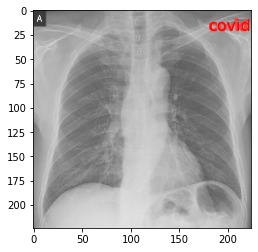

In [7]:
# one of image look like, the last one:

plt.imshow(image,alpha=60)
plt.text(180,20,label,fontsize=16,color="red")

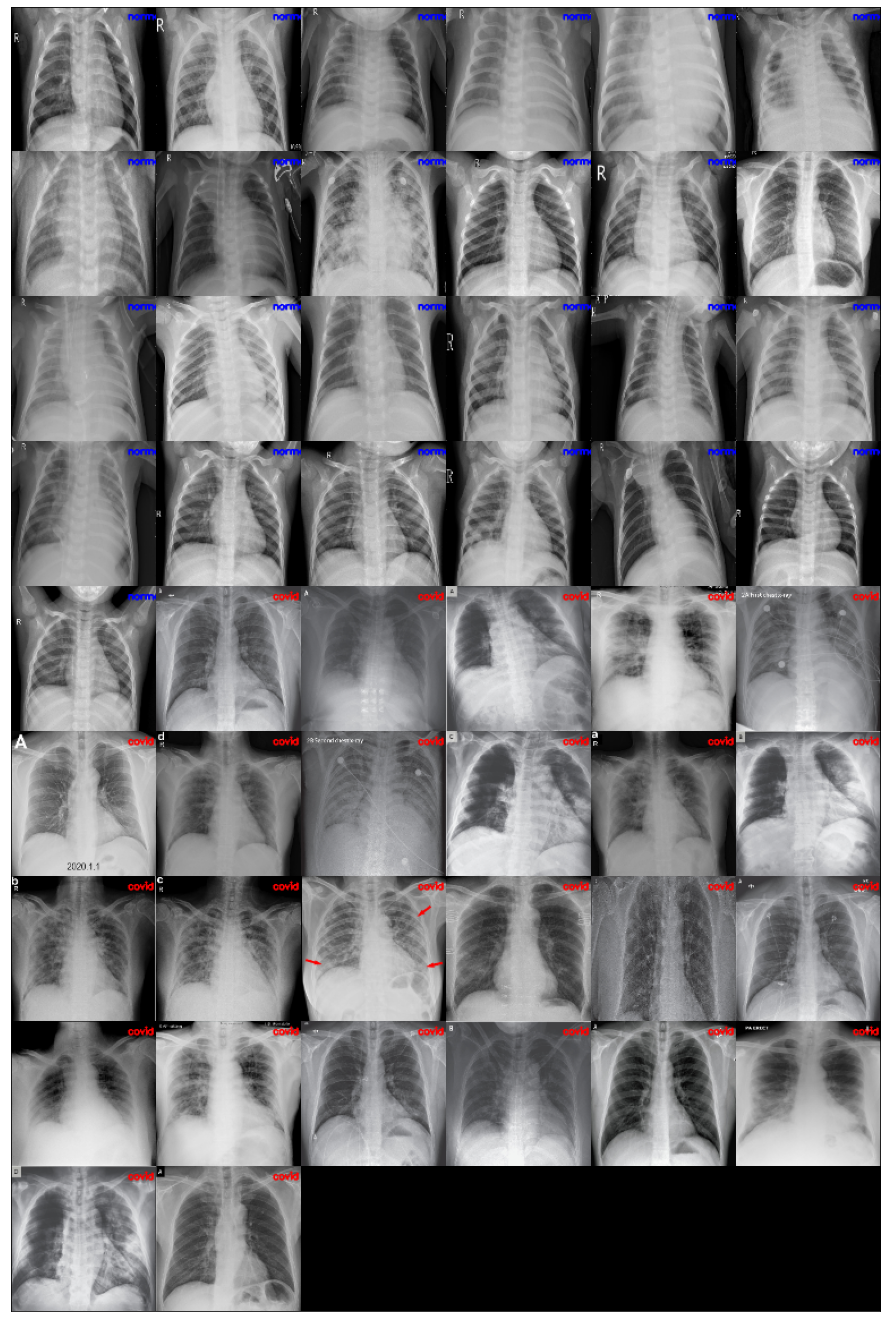

In [8]:
# list all the images
montage = build_montages(images, (128, 128), (6, 9))[0]
plt.figure(figsize=(20,24))
plt.imshow(montage)
plt.xticks([]);plt.yticks([]);

Convolution with Image
---
1. In Deep learning Modelling, it is very convenient to retrieve features from image by  convolution operation , $f\circ\text{ kernel }$:
```
          kernel for vrtical filter
             1 0 -1  
   image  +  1 0 -1 
             1 0 -1
```             

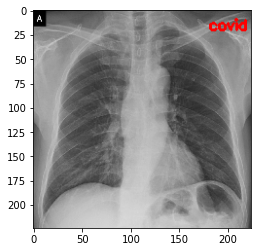

In [13]:
#img = cv2.imread('images/input.jpg')
#gray=cv2.cvtColor(img,cv2.COLOR_BGR2BRAY)

rows,cols = image.shape[:2]

plt.imshow(image)


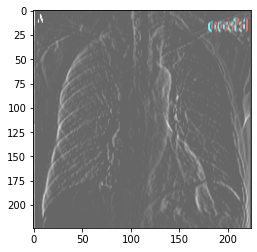

In [18]:
kernel_vedge = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
output=cv2.filter2D(image,-1,kernel_vedge)
plt.imshow(output,alpha=0.6)


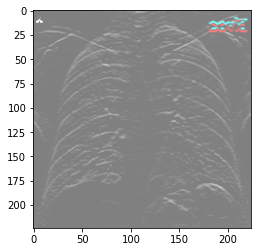

In [20]:
kernel_hedge = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
output1=cv2.filter2D(image,-1,kernel_hedge)
plt.imshow(output1,alpha=0.5)

In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
# before shuffle the images order, define the order sequence 
Ind=np.arange(len(labels))

In [11]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
# coincide with the order of images after splitting and shaffling

(trainX, testX, trainY, testY, IndX, IndY) = train_test_split(data, labels,Ind,
                            test_size=0.20, stratify=labels, random_state=2020)


In [33]:
# initialize the training data augmentation object, batch by rotating image by 15 degrees 

trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")


In [21]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
baseModel.summary()

In [24]:
# create sub-folder here , named VGG16

baseModel.save("VGG16")#, save_format="h5")

INFO:tensorflow:Assets written to: VGG16/assets


In [25]:
models_saved="VGG16"
if models_saved:
   baseModel=tf.keras.models.load_model(models_saved)

In [24]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation=gelu)(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [25]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


In [ ]:
model.summary()

In [28]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False


In [35]:
# compile our model
print("[INFO] compiling model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BS),
                        steps_per_epoch=len(trainX) // BS,
                        validation_data=(testX, testY),
                        validation_steps=len(testX) // BS,
                        epochs=EPOCHS)

In [ ]:
model.summary()

In [38]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...


In [39]:
predIdxs

array([[0.7443767 , 0.2556233 ],
       [0.9050083 , 0.09499169],
       [0.22666605, 0.77333397],
       [0.05825641, 0.94174355],
       [0.06297514, 0.93702483],
       [0.96643627, 0.03356376],
       [0.6387403 , 0.3612598 ],
       [0.2555273 , 0.7444727 ],
       [0.62438023, 0.37561986],
       [0.10878903, 0.891211  ]], dtype=float32)

In [40]:
testY

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [41]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability

predIdxs = np.argmax(predIdxs, axis=1)


In [42]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))


              precision    recall  f1-score   support

       covid       0.80      0.80      0.80         5
      normal       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



In [43]:
# show a nicely formatted classification report, gelu
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))


              precision    recall  f1-score   support

       covid       0.80      0.80      0.80         5
      normal       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



In [44]:

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [45]:
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[[4 1]
 [1 4]]
acc: 0.8000
sensitivity: 0.8000
specificity: 0.8000


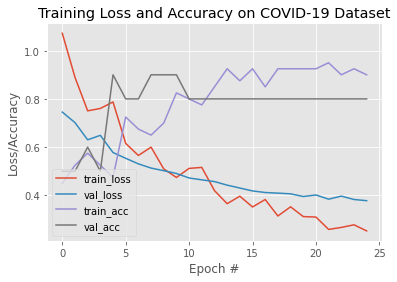

In [46]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("covid.png")



In [33]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save("model-2020-06-10", save_format="h5")

[INFO] saving COVID-19 detector model...


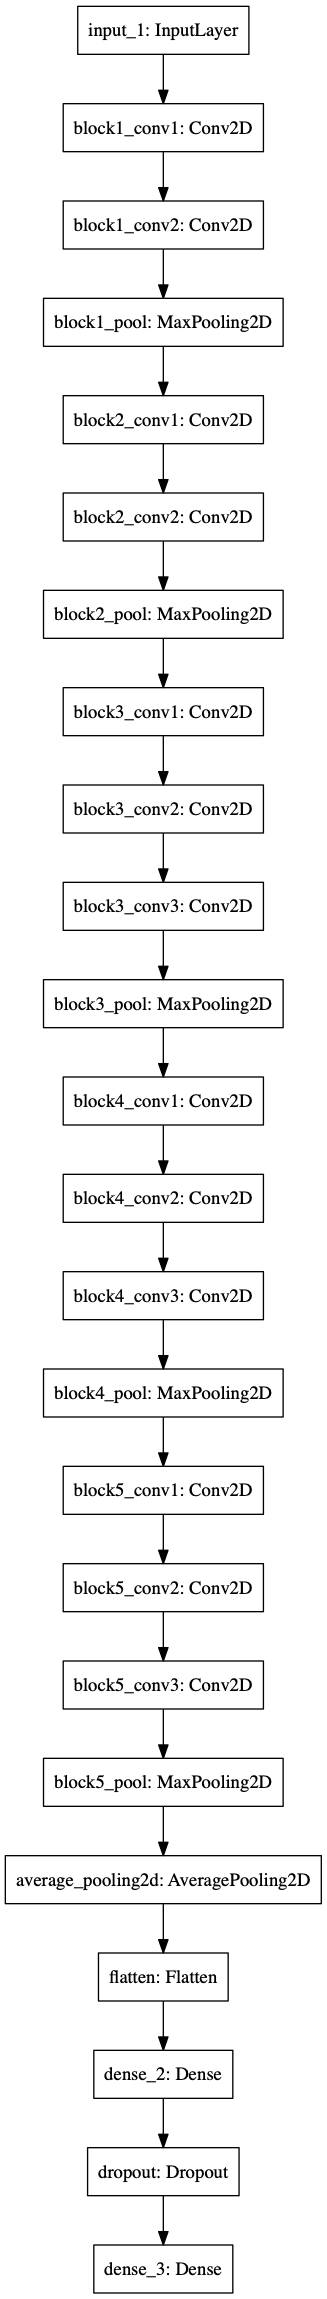

In [47]:
tf.keras.utils.plot_model(
    model, to_file='Covid-19_tf_model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)